Tamaño del conjunto de entrenamiento: 236
Tamaño del conjunto de validación: 79
Tamaño del conjunto de prueba: 79

Resultados en el conjunto de validación:
AUC-ROC: 0.6605769230769231


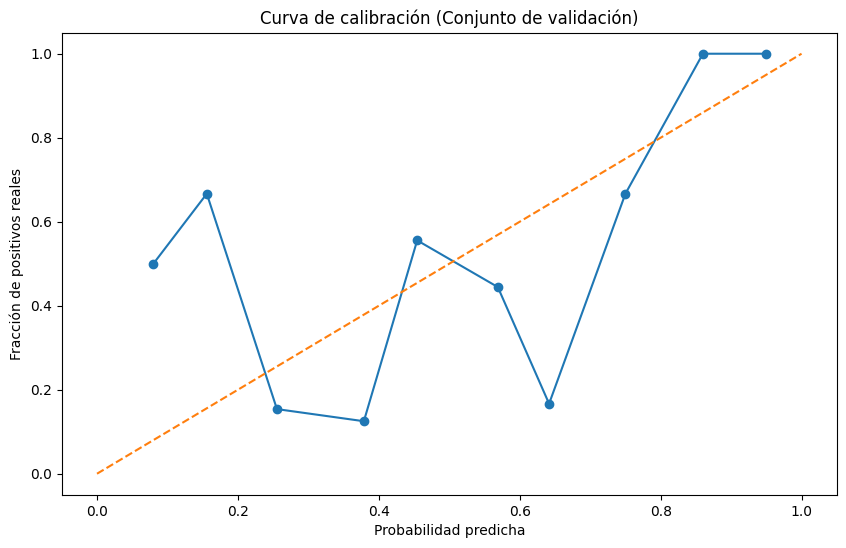


Importancia de características:
                          feature  importance
3               avg_glucose_level    0.400514
0                             age    0.329498
2                   heart_disease    0.068827
1                    hypertension    0.064251
8           smoking_status_smokes    0.032603
4                   gender_Female    0.027444
5                     gender_Male    0.026799
6  smoking_status_formerly smoked    0.025899
7     smoking_status_never smoked    0.024165

Resultados finales en el conjunto de prueba:
AUC-ROC: 0.7131410256410257

Ejemplos de predicciones probabilísticas (conjunto de prueba):
Muestra 1: Probabilidad de ictus = 12.00%
Muestra 2: Probabilidad de ictus = 59.00%
Muestra 3: Probabilidad de ictus = 58.00%
Muestra 4: Probabilidad de ictus = 49.00%
Muestra 5: Probabilidad de ictus = 93.00%


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv('stroke_dataset_processed_balanced.csv')

# Separar características y variable objetivo
X = df.drop('stroke', axis=1)
y = df['stroke']

# Primer split: separar el conjunto de prueba
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Segundo split: separar conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de validación:", X_val.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar en el conjunto de validación
y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]
print("\nResultados en el conjunto de validación:")
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred_proba))

# Calibración del modelo en el conjunto de validación
prob_true, prob_pred = calibration_curve(y_val, y_val_pred_proba, n_bins=10)

# Visualizar la curva de calibración
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Fracción de positivos reales')
plt.title('Curva de calibración (Conjunto de validación)')
plt.show()

# Importancia de características
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
print("\nImportancia de características:")
print(feature_importance.sort_values('importance', ascending=False))

# Evaluación final en el conjunto de prueba
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]
print("\nResultados finales en el conjunto de prueba:")
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred_proba))

# Ejemplo de predicciones probabilísticas en el conjunto de prueba
sample_predictions = y_test_pred_proba[:5]
print("\nEjemplos de predicciones probabilísticas (conjunto de prueba):")
for i, prob in enumerate(sample_predictions):
    print(f"Muestra {i+1}: Probabilidad de ictus = {prob:.2%}")

In [50]:
print("\n--- Optimización de hiperparámetros para RandomForest ---")
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42)

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, verbose=2, random_state=42, 
                                   n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor score
print("Mejores parámetros para RandomForest:", random_search.best_params_)
print("Mejor AUC-ROC en validación cruzada:", random_search.best_score_)

# Usar el mejor modelo de RandomForest
best_rf = random_search.best_estimator_
y_test_pred_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]
print("AUC-ROC del mejor RandomForest en conjunto de prueba:", roc_auc_score(y_test, y_test_pred_proba_best_rf))


--- Optimización de hiperparámetros para RandomForest ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para RandomForest: {'max_depth': 31, 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 114}
Mejor AUC-ROC en validación cruzada: 0.6077445652173912
AUC-ROC del mejor RandomForest en conjunto de prueba: 0.7016025641025642


In [51]:
print("\n--- Optimización de hiperparámetros para modelos individuales ---")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

# Definir espacios de búsqueda para cada modelo
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

gb_params = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

svm_params = {
    'C': uniform(0.1, 10),
    'kernel': ['rbf', 'poly'],
    'gamma': uniform(0.01, 1)
}

nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': uniform(0.0001, 0.1),
    'learning_rate_init': uniform(0.001, 0.01)
}

# Función para realizar búsqueda aleatoria
def random_search(estimator, param_distributions, name):
    rs = RandomizedSearchCV(estimator, param_distributions, n_iter=50, cv=5, 
                            verbose=2, random_state=42, n_jobs=-1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    print(f"Mejores parámetros para {name}:", rs.best_params_)
    print(f"Mejor AUC-ROC en validación cruzada para {name}:", rs.best_score_)
    return rs.best_estimator_

# Realizar búsqueda para cada modelo
best_rf = random_search(RandomForestClassifier(random_state=42), rf_params, "RandomForest")
best_gb = random_search(GradientBoostingClassifier(random_state=42), gb_params, "GradientBoosting")
best_svm = random_search(SVC(probability=True, random_state=42), svm_params, "SVM")
best_nn = random_search(MLPClassifier(max_iter=1000, random_state=42), nn_params, "Neural Network")

# Crear un nuevo ensemble con los mejores modelos
best_ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb), ('svm', best_svm), ('nn', best_nn)],
    voting='soft'
)

# Entrenar el mejor ensemble
best_ensemble.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred_proba_best_ensemble = best_ensemble.predict_proba(X_test)[:, 1]
print("\n--- Resultados del mejor modelo (Ensemble optimizado) ---")
print("AUC-ROC en conjunto de prueba:", roc_auc_score(y_test, y_pred_proba_best_ensemble))


# Evaluar en el conjunto de prueba
y_pred_proba_best_ensemble = best_ensemble.predict_proba(X_test)[:, 1]
print("\n--- Resultados del mejor modelo (Ensemble optimizado) ---")
print("AUC-ROC en conjunto de prueba:", roc_auc_score(y_test, y_pred_proba_best_ensemble))

# Nuevo bloque de código para análisis adicional
print("\n--- Análisis adicional y refinamiento del ensemble ---")

# Validación cruzada consistente
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Calibración de probabilidades
calibrated_ensemble = CalibratedClassifierCV(best_ensemble, cv=5, method='sigmoid')
calibrated_ensemble.fit(X_train, y_train)

# Evaluación del ensemble calibrado
y_pred_proba_calibrated = calibrated_ensemble.predict_proba(X_test)[:, 1]
print("AUC-ROC del ensemble calibrado:", roc_auc_score(y_test, y_pred_proba_calibrated))

# Análisis de errores
incorrect_predictions = X_test[y_test != (y_pred_proba_best_ensemble > 0.5)]
print("Características de las predicciones incorrectas:")
print(incorrect_predictions.describe())

# Ajuste de pesos en el ensemble
weighted_ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb), ('svm', best_svm), ('nn', best_nn)],
    voting='soft',
    weights=[2, 1, 1, 1]  # Ajusta estos pesos según el rendimiento individual
)
weighted_ensemble.fit(X_train, y_train)
y_pred_proba_weighted = weighted_ensemble.predict_proba(X_test)[:, 1]
print("AUC-ROC del ensemble ponderado:", roc_auc_score(y_test, y_pred_proba_weighted))

# Comparación final
print("\n--- Comparación final de modelos ---")
print("RandomForest original AUC-ROC:", roc_auc_score(y_test, y_test_pred_proba))
print("Mejor RandomForest AUC-ROC:", roc_auc_score(y_test, y_test_pred_proba_best_rf))
print("Mejor Ensemble AUC-ROC:", roc_auc_score(y_test, y_pred_proba_best_ensemble))
print("Ensemble Calibrado AUC-ROC:", roc_auc_score(y_test, y_pred_proba_calibrated))
print("Ensemble Ponderado AUC-ROC:", roc_auc_score(y_test, y_pred_proba_weighted))


--- Optimización de hiperparámetros para modelos individuales ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para RandomForest: {'max_depth': 31, 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 114}
Mejor AUC-ROC en validación cruzada para RandomForest: 0.6077445652173912
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para GradientBoosting: {'learning_rate': 0.1002634929450309, 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 18, 'n_estimators': 286}
Mejor AUC-ROC en validación cruzada para GradientBoosting: 0.5648550724637681
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para SVM: {'C': 0.17066305219717406, 'gamma': 0.03306242504141576, 'kernel': 'rbf'}
Mejor AUC-ROC en validación cruzada para SVM: 0.6304800724637681
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para Neural Network: {'alpha': 0.025029222914887496, 'hi

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC-ROC del ensemble calibrado: 0.7455128205128205
Características de las predicciones incorrectas:
             age  hypertension  heart_disease  avg_glucose_level  \
count  26.000000     26.000000      26.000000          26.000000   
mean    0.625517      0.534441       0.631259           0.861340   
std     0.686733      1.405493       1.685595           1.058464   
min    -0.678238     -0.384358      -0.274051          -1.051510   
25%     0.338691     -0.384358      -0.274051          -0.063338   
50%     0.536427     -0.384358      -0.274051           0.879312   
75%     1.172008      2.601740      -0.274051           1.704425   
max     1.638100      2.601740       3.648958           2.823842   

       gender_Female  gender_Male  smoking_status_formerly smoked  \
count      26.000000    26.000000                       26.000000   
mean        0.500000     0.500000                        0.423077   
std         0.509902     0.509902                        0.503831   
min        

In [59]:
from joblib import dump

# Guardar el ensemble calibrado
dump(calibrated_ensemble, 'ensemble_calibrado.joblib')

# Guardar el preprocesador completo
dump(preprocessor, 'preprocessor.joblib')

# Guardar los nombres de las características después del preprocesamiento
dump(feature_names, 'feature_names.joblib')

print("Modelo, preprocesador y nombres de características guardados.")

Modelo, preprocesador y nombres de características guardados.
